Підключення усіх необхідних бібліотек

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Створення функцій для EDA обробки

In [2]:
# ----- Функція знаходження пропущених даних -----
def missing_values(df, name="dataset"):
    # шукаємо кількість пропущених в кожноій колонці
    missing = df.isna().sum()
    percent = (missing / len(df)) * 100
    report = pd.DataFrame({'Пропуски': missing, 'Відсоток': percent})

    # відсортована таблиця зі стовпцями
    report = report[report['Пропуски'] > 0].sort_values('Відсоток', ascending=False)

    print(f"\n[{name}] Пропущені значення у всіх колонках:")
    if report.empty:
        print("Пропусків немає.")
    else:
        print(report)

    return report

# ----- Функція перевірки дублікатів -----
def check_duplicates(df, name="dataset"):
    duplicates = df.duplicated().sum()
    print(f"\n[{name}] Кількість дублікатів: {duplicates}")
    return duplicates

# ----- Функція перевірки типів даних -----
def check_dtypes(df, name="dataset"):
    print(f"\n[{name}] Типи даних:")
    print(df.dtypes)

    num_cols = df.select_dtypes(include=['number']).columns
    cat_cols = df.select_dtypes(exclude=['number']).columns

    print(f"\n[{name}] Кількість числових колонок: {len(num_cols)}")
    print(f"[{name}] Кількість нечислових колонок: {len(cat_cols)}")

    return num_cols, cat_cols

# ----- Функція побудови графіків
def plot_distributions(df, name="dataset", sample_size=12):
    num_cols = df.select_dtypes(include='number').columns
    cat_cols = df.select_dtypes(exclude='number').columns

    print(f"\n[{name}] Побудова графіків розподілу:")

    # числові змінні
    for col in num_cols[:sample_size]:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # гістограма
        sns.histplot(df[col].dropna(), bins=30, ax=axes[0])
        axes[0].set_title(f"{col} - Гістограма")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("Кількість")

        # Boxplot
        sns.boxplot(x=df[col].dropna(), ax=axes[1])
        axes[1].set_title(f"{col} - Boxplot")
        axes[1].set_xlabel(col)

        plt.suptitle(f"{name}: розподіл {col}", fontsize=12)
        plt.tight_layout()
        plt.show()

    # категоріальні змінні
    for col in cat_cols[:sample_size]:
        plt.figure(figsize=(6, 4))
        df[col].value_counts().plot(kind='bar', color='skyblue')
        plt.title(f"{name}: Частота категорій у {col}")
        plt.xlabel(col)
        plt.ylabel("Кількість")
        plt.tight_layout()
        plt.show()

# ----- Функція заповнення пропущених значень середнім -----
def fill_missing(df, name="dataset"):
    numeric_cols = df.select_dtypes(include='number').columns
    df_filled = df.copy()
    
    print(f"\n[{name}] Заповнення пропущених числових значень медіанами:")
    for col in numeric_cols:
        missing_count = df_filled[col].isna().sum()
        if missing_count > 0:
            median_value = df_filled[col].median()
            df_filled[col] = df_filled[col].fillna(median_value)
            print(f"  - {col}: замінено {missing_count} пропусків (медіана = {median_value:.2f})")

    if df_filled[numeric_cols].isna().sum().sum() == 0:
        print("Усі числові пропуски заповнені")
    else:
        print("Деякі пропуски залишились")
    
    return df_filled

def log_num_and_cast_cat(df: pd.DataFrame, exclude: list = None) -> pd.DataFrame:
    out = df.copy()
    exclude = set(exclude or [])
    # числові (без exclude)
    num_cols = [c for c in out.select_dtypes(include='number').columns if c not in exclude]
    out[num_cols] = np.log1p(out[num_cols].clip(lower=0))
    # object -> category
    obj_cols = out.select_dtypes(include='object').columns
    out[obj_cols] = out[obj_cols].astype('category')
    return out

Читаємо тренувальний та тестовий датасети

In [3]:
df_train = pd.read_csv("application_train.csv")
df_test = pd.read_csv("application_test.csv")

В першу чергу варто обмежити кількість колонок, на основі яких будемо навчати нашу модель, а саме:
- TARGET (цільова змінна) - вказує, чи клієнт повернув кредит. 0 - кредит повернуто; 1 - кредит не повернуто.
- AMT_INCOME_TOTAL (загальний дохід) - сукупний місячний дохід позичальника.
- AMT_CREDIT (сума кредиту) - розмір виданого кредиту.
- AMT_ANNUITY (сума анюїтету) - розмір щомісячного платежу за кредитом.
- AMT_GOODS_PRICE (вартість товару) - ціна товару або послуги, що кредитується.
- DAYS_BIRTH (вік у днях) - кількість днів з моменту народження (від’ємне число). Чим менше значення, тим старший клієнт.
- DAYS_EMPLOYED (дні роботи) - кількість днів, протягом яких клієнт офіційно працює (також від’ємне число).
- CODE_GENDER (стать клієнта) - стать позичальника. M - чоловік; F - жінка; XNA - не вказано.
- NAME_EDUCATION_TYPE (освіта клієнта) - найвищий рівень освіти. Варіанти: Secondary / secondary special (середня), Higher education (вища), Incomplete higher (незакінчена вища), Lower secondary (нижча середня), Academic degree (науковий ступінь).
- NAME_FAMILY_STATUS (сімейний стан) - поточний сімейний стан клієнта. Варіанти: Married (одружений), Single / not married (неодружений), Civil marriage (цивільний шлюб), Widow (вдівець), Separated (розлучений).
- NAME_HOUSING_TYPE (тип житла) - тип житлової ситуації позичальника. Варіанти: House / apartment (власне житло), With parents (живе з батьками), Rented apartment (орендоване), Municipal apartment (комунальне), Office apartment (службове), Co-op apartment (кооперативне).

Почнемо приводити кожну колонку з даними до робочого вигляду. Почнемо з 'TARGET'.


[dataset] Побудова графіків розподілу:


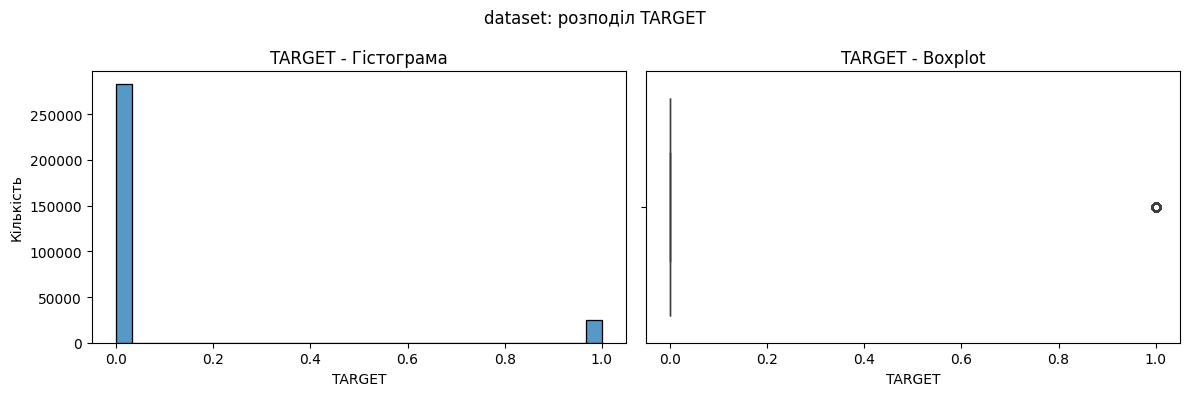

In [4]:
plot_distributions(df_train[['TARGET']], sample_size=1)

З графіку видно, що розподіл нерівномірний. Сталося це через те, що у нас непарвильний тип змінної.


[dataset] Побудова графіків розподілу:


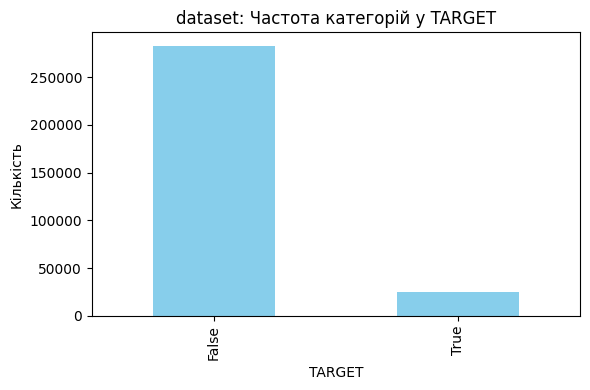

In [5]:
df_train['TARGET'] = df_train['TARGET'].astype(bool)
plot_distributions(df_train[['TARGET']], sample_size=1)

Далі на черзі 'DAYS_BIRTH'. Розподіл даних нормальний, однак значення не дуже зручні для користування, тому переведемо дні в роки.


[dataset] Побудова графіків розподілу:


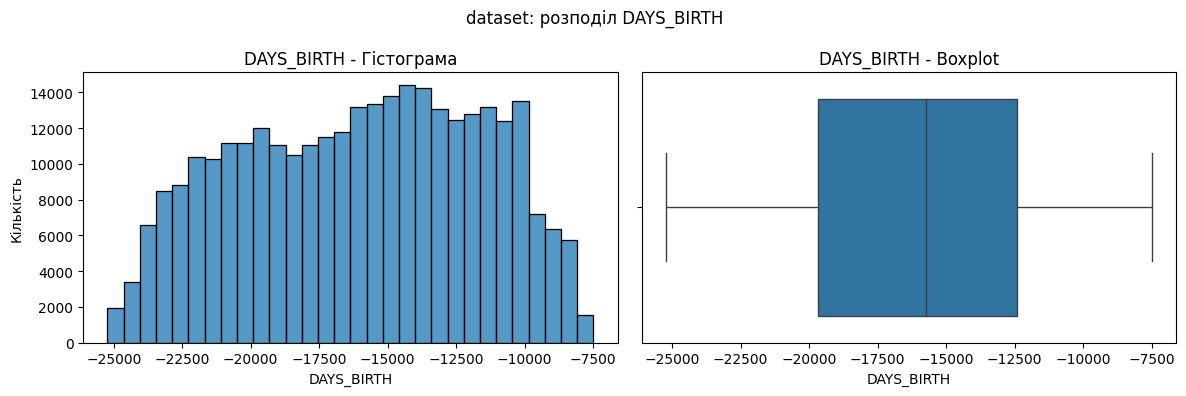

In [6]:
plot_distributions(df_train[['DAYS_BIRTH']], sample_size=1)


[dataset] Побудова графіків розподілу:


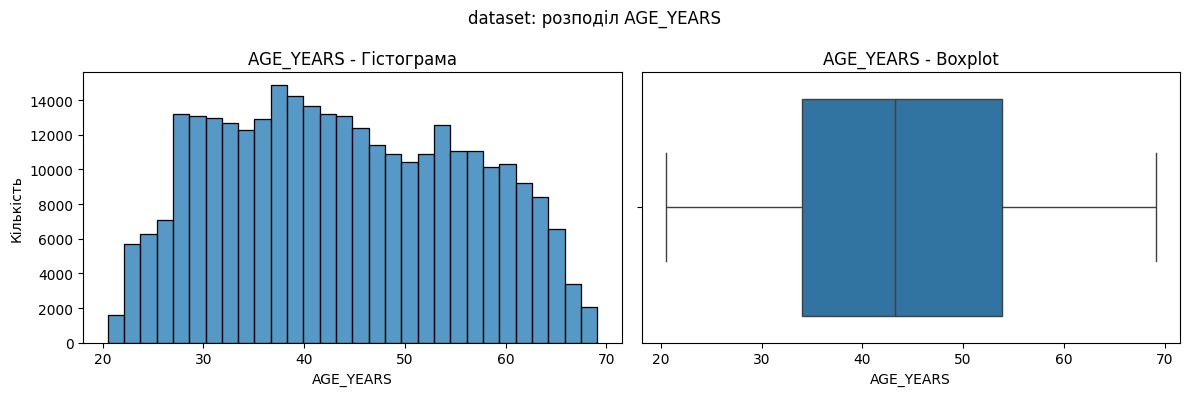

In [7]:
if 'DAYS_BIRTH' in df_train.columns:
    df_train['AGE_YEARS'] = (-df_train['DAYS_BIRTH'] / 365).round(1)
    df_train = df_train.drop(columns=['DAYS_BIRTH'])

plot_distributions(df_train[['AGE_YEARS']], sample_size=1)

Наступниа колонка в нас 'DAYS_EMPLOYED'. Бачимо сміттєві значення, тому маємо від них позбутися і для зручності перевести дні в роки. Також пролагорифмуємо значення, аби отримати розподіл без зайвих хвостів на Боксплоті.


[dataset] Побудова графіків розподілу:


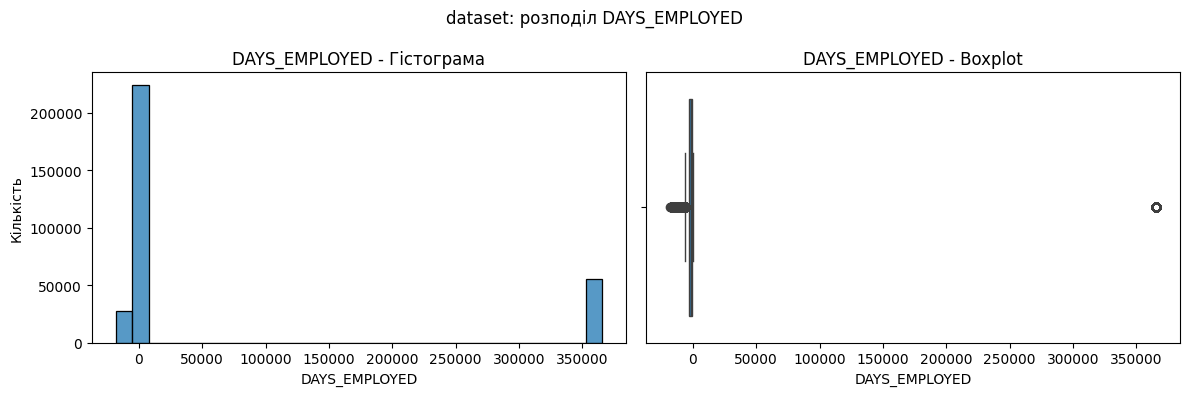

In [8]:
plot_distributions(df_train[['DAYS_EMPLOYED']], sample_size=1)


[dataset] Побудова графіків розподілу:


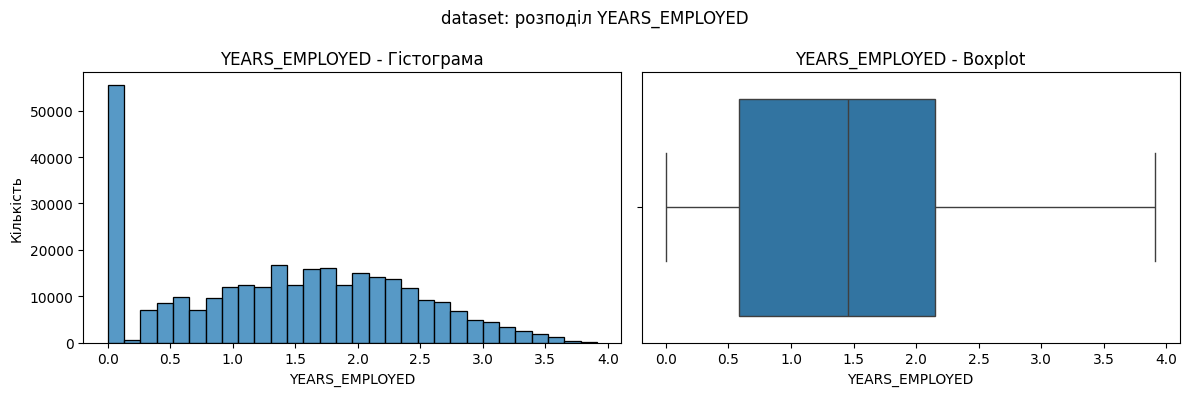

In [9]:
if 'DAYS_EMPLOYED' in df_train.columns:
    df_train.loc[df_train['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = 0
    df_train['YEARS_EMPLOYED'] = (-df_train['DAYS_EMPLOYED'] / 365).round(1)
    df_train = df_train.drop(columns=['DAYS_EMPLOYED'])

df_train['YEARS_EMPLOYED'] = np.log1p(df_train['YEARS_EMPLOYED'])

plot_distributions(df_train[['YEARS_EMPLOYED']], sample_size=1)

На графіку колонки 'AMT_INCOME_TOTAL' одразу видно сміттєві значення, від яких ми маємо позбутися, а також одразу логарифмуємо.


[dataset] Побудова графіків розподілу:


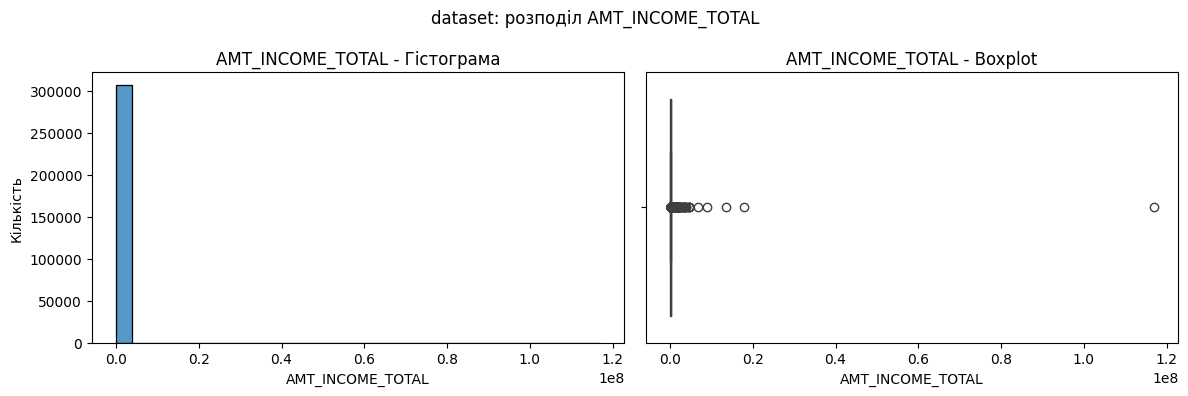

In [10]:
plot_distributions(df_train[['AMT_INCOME_TOTAL']], sample_size=1)


[dataset] Побудова графіків розподілу:


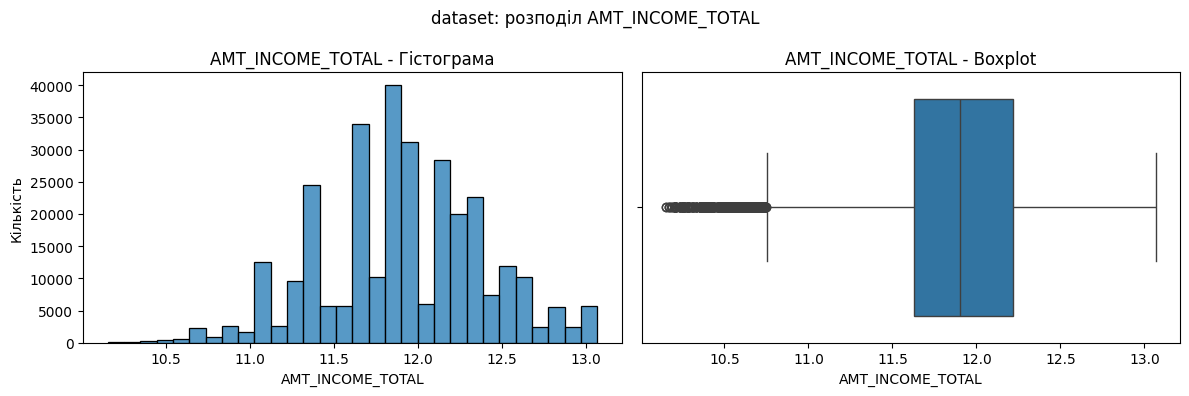

In [11]:
q99 = df_train['AMT_INCOME_TOTAL'].quantile(0.99)
df_train.loc[df_train['AMT_INCOME_TOTAL'] > q99, 'AMT_INCOME_TOTAL'] = q99

df_train['AMT_INCOME_TOTAL'] = np.log1p(df_train['AMT_INCOME_TOTAL'])

plot_distributions(df_train[['AMT_INCOME_TOTAL']], sample_size=1)

Останні 3 чисельні колонки 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE' потребують логарифмування, аби врівноважити дані на графіку розподілу.


[dataset] Побудова графіків розподілу:


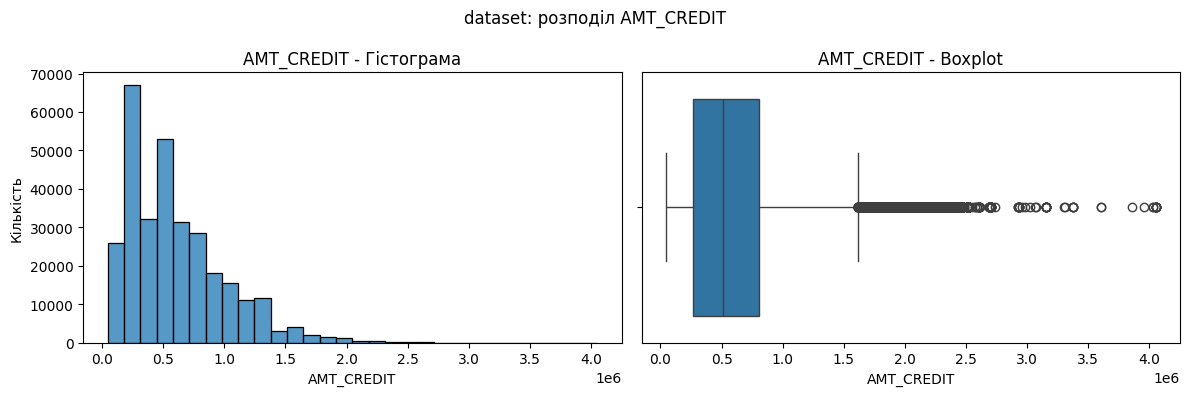

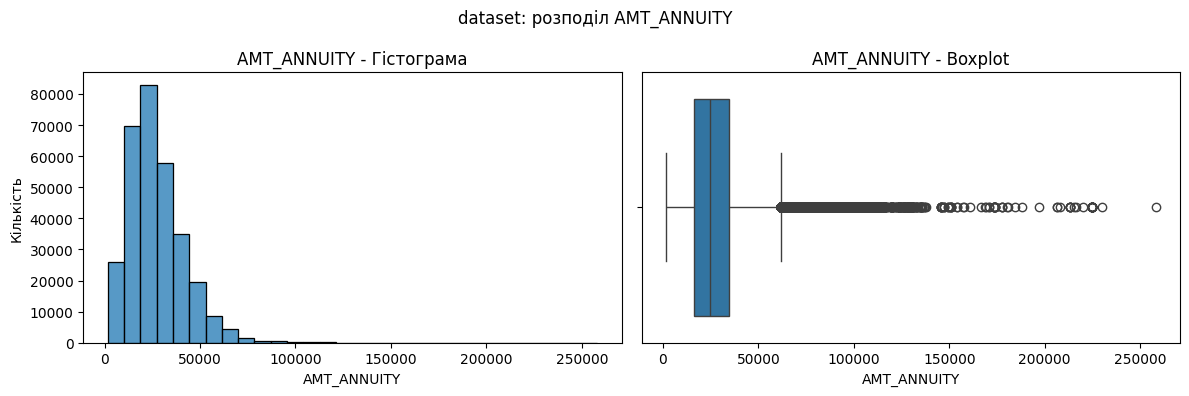

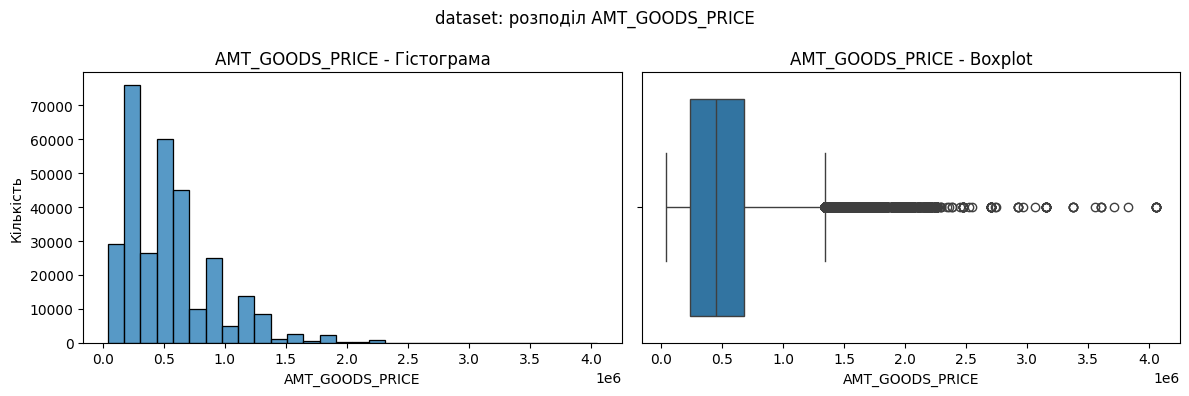

In [12]:
plot_distributions(df_train[['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']], sample_size=3)


[dataset] Побудова графіків розподілу:


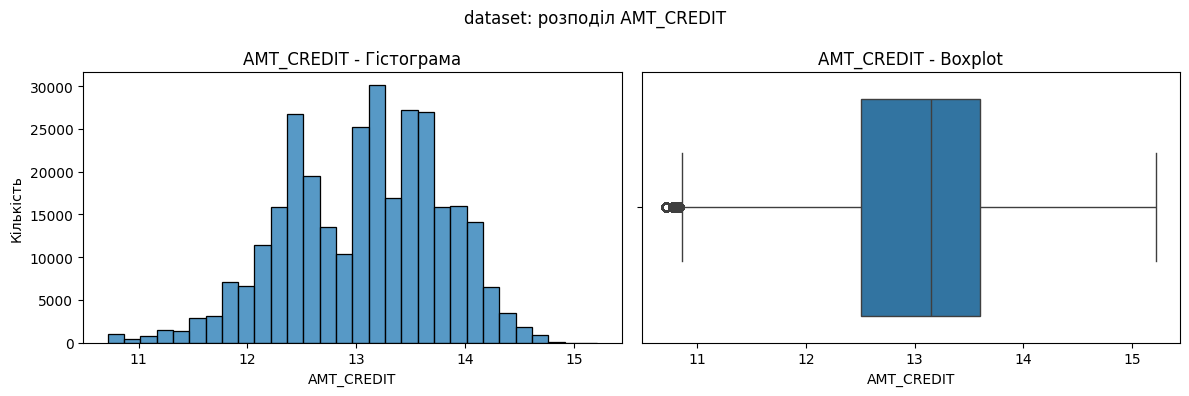

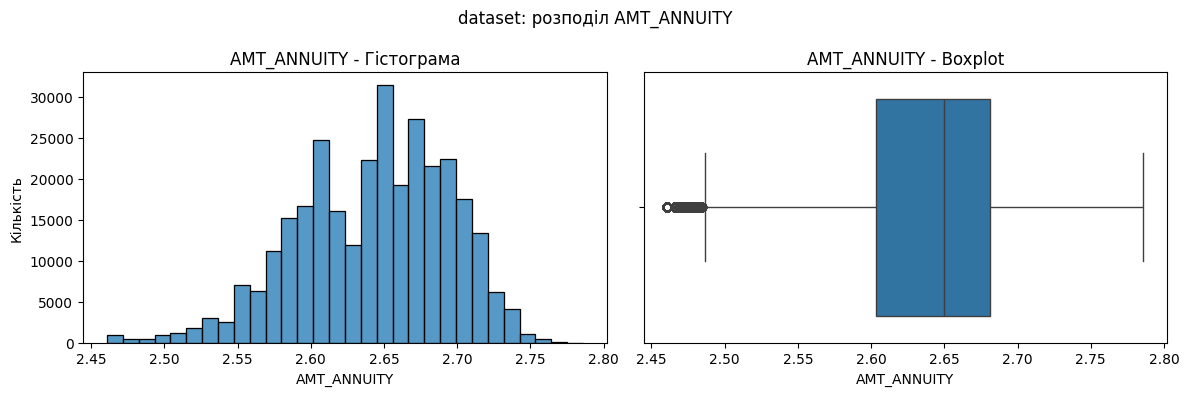

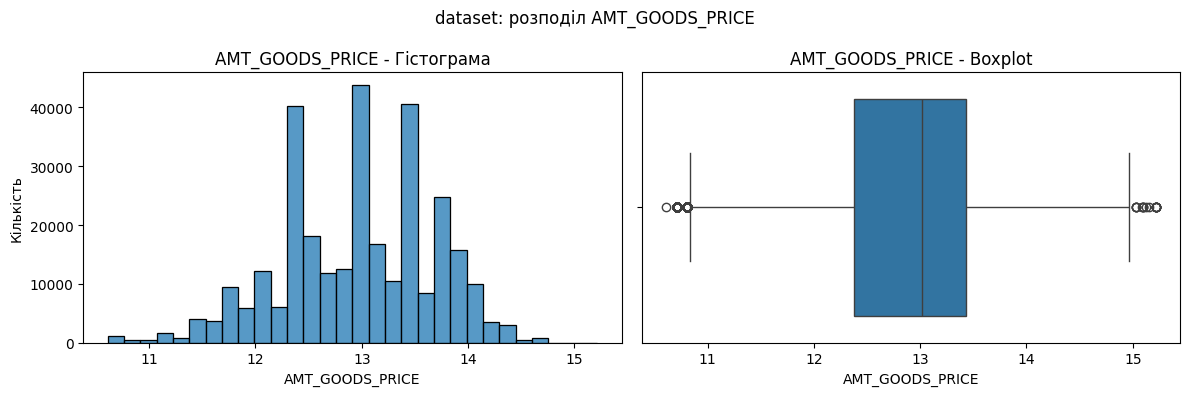

In [13]:
df_train['AMT_CREDIT'] = np.log1p(df_train['AMT_CREDIT'])
df_train['AMT_ANNUITY'] = np.log1p(df_train['AMT_CREDIT'])
df_train['AMT_GOODS_PRICE'] = np.log1p(df_train['AMT_GOODS_PRICE'])

plot_distributions(df_train[['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']], sample_size=3)

Категоріальні колокни переводимо у тип даних 'category'.


[dataset] Побудова графіків розподілу:


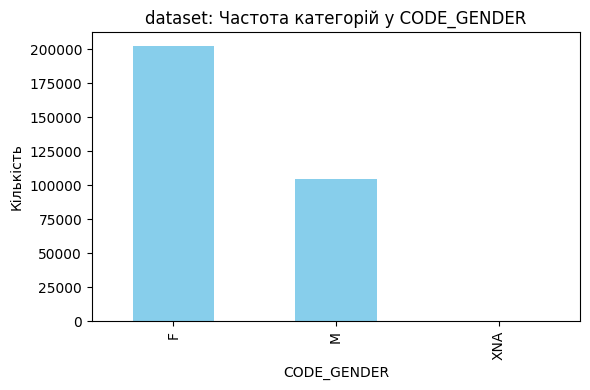

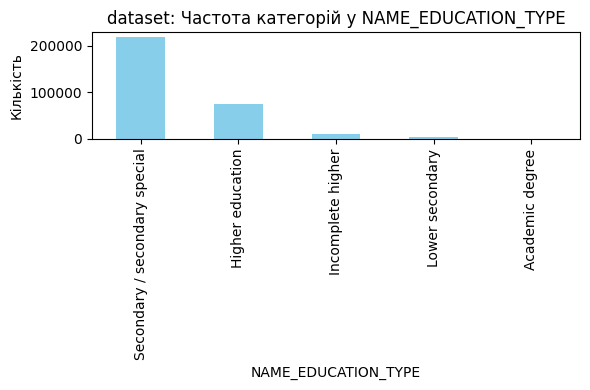

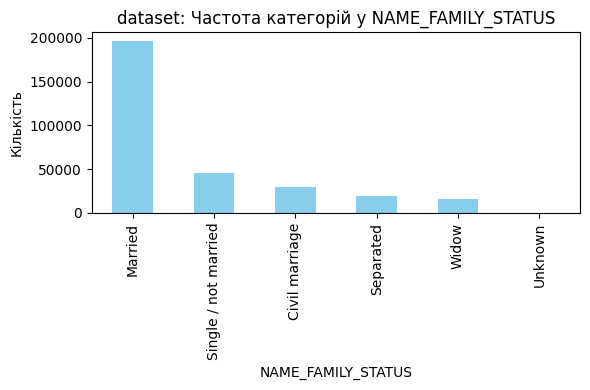

In [14]:
cat_cols = ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']
df_train[cat_cols] = df_train[cat_cols].astype('category')
plot_distributions(df_train[cat_cols], sample_size=3)

Далі шукаємо пропущені значення й заповнюємо їх медіанами.

In [15]:
missing_values(df_train, "Train")
df_train = fill_missing(df_train, "Train")


[Train] Пропущені значення у всіх колонках:
                          Пропуски   Відсоток
COMMONAREA_MODE             214865  69.872297
COMMONAREA_AVG              214865  69.872297
COMMONAREA_MEDI             214865  69.872297
NONLIVINGAPARTMENTS_MEDI    213514  69.432963
NONLIVINGAPARTMENTS_MODE    213514  69.432963
...                            ...        ...
OBS_30_CNT_SOCIAL_CIRCLE      1021   0.332021
EXT_SOURCE_2                   660   0.214626
AMT_GOODS_PRICE                278   0.090403
CNT_FAM_MEMBERS                  2   0.000650
DAYS_LAST_PHONE_CHANGE           1   0.000325

[66 rows x 2 columns]

[Train] Заповнення пропущених числових значень медіанами:
  - AMT_GOODS_PRICE: замінено 278 пропусків (медіана = 13.02)
  - OWN_CAR_AGE: замінено 202929 пропусків (медіана = 9.00)
  - CNT_FAM_MEMBERS: замінено 2 пропусків (медіана = 2.00)
  - EXT_SOURCE_1: замінено 173378 пропусків (медіана = 0.51)
  - EXT_SOURCE_2: замінено 660 пропусків (медіана = 0.57)
  - EXT_SOURCE_3: зам

Також варто перевірити наявність дублікатів та типи даних.

In [16]:
missing_values(df_train, "Train")
check_duplicates(df_train, "Train")
check_dtypes(df_train, "Train")


[Train] Пропущені значення у всіх колонках:
                     Пропуски   Відсоток
FONDKAPREMONT_MODE     210295  68.386172
WALLSMATERIAL_MODE     156341  50.840783
HOUSETYPE_MODE         154297  50.176091
EMERGENCYSTATE_MODE    145755  47.398304
OCCUPATION_TYPE         96391  31.345545
NAME_TYPE_SUITE          1292   0.420148

[Train] Кількість дублікатів: 0

[Train] Типи даних:
SK_ID_CURR                       int64
TARGET                            bool
NAME_CONTRACT_TYPE              object
CODE_GENDER                   category
FLAG_OWN_CAR                    object
                                ...   
AMT_REQ_CREDIT_BUREAU_MON      float64
AMT_REQ_CREDIT_BUREAU_QRT      float64
AMT_REQ_CREDIT_BUREAU_YEAR     float64
AGE_YEARS                      float64
YEARS_EMPLOYED                 float64
Length: 122, dtype: object

[Train] Кількість числових колонок: 105
[Train] Кількість нечислових колонок: 17


(Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
        'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
        'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
        ...
        'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
        'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
        'AMT_REQ_CREDIT_BUREAU_YEAR', 'AGE_YEARS', 'YEARS_EMPLOYED'],
       dtype='object', length=105),
 Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
        'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
        'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
        'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
        'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
        'EMERGENCYSTATE_MODE'],
       dtype='object'))

Проводимо аналогічну чистку на даних для тестування

In [17]:
if 'DAYS_BIRTH' in df_test.columns:
    df_test['AGE_YEARS'] = (-df_test['DAYS_BIRTH'] / 365).round(1)
    df_test = df_test.drop(columns=['DAYS_BIRTH'])
if 'DAYS_EMPLOYED' in df_test.columns:
    df_test.loc[df_test['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = 0
    df_test['YEARS_EMPLOYED'] = (-df_test['DAYS_EMPLOYED'] / 365).round(1)
    df_test = df_test.drop(columns=['DAYS_EMPLOYED'])

q99 = df_test['AMT_INCOME_TOTAL'].quantile(0.99)
df_test.loc[df_test['AMT_INCOME_TOTAL'] > q99, 'AMT_INCOME_TOTAL'] = q99

df_test['AMT_CREDIT'] = np.log1p(df_test['AMT_CREDIT'])
df_test['AMT_ANNUITY'] = np.log1p(df_test['AMT_CREDIT'])
df_test['AMT_GOODS_PRICE'] = np.log1p(df_test['AMT_GOODS_PRICE'])
df_test['AMT_INCOME_TOTAL'] = np.log1p(df_test['AMT_INCOME_TOTAL'])
df_test['YEARS_EMPLOYED'] = np.log1p(df_test['YEARS_EMPLOYED'])

cat_cols = ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']
df_test[cat_cols] = df_test[cat_cols].astype('category')

df_test = fill_missing(df_test, "Train")
check_duplicates(df_test, "Train")
check_dtypes(df_test, "Train")


[Train] Заповнення пропущених числових значень медіанами:
  - OWN_CAR_AGE: замінено 32312 пропусків (медіана = 9.00)
  - EXT_SOURCE_1: замінено 20532 пропусків (медіана = 0.51)
  - EXT_SOURCE_2: замінено 8 пропусків (медіана = 0.56)
  - EXT_SOURCE_3: замінено 8668 пропусків (медіана = 0.52)
  - APARTMENTS_AVG: замінено 23887 пропусків (медіана = 0.09)
  - BASEMENTAREA_AVG: замінено 27641 пропусків (медіана = 0.08)
  - YEARS_BEGINEXPLUATATION_AVG: замінено 22856 пропусків (медіана = 0.98)
  - YEARS_BUILD_AVG: замінено 31818 пропусків (медіана = 0.76)
  - COMMONAREA_AVG: замінено 33495 пропусків (медіана = 0.02)
  - ELEVATORS_AVG: замінено 25189 пропусків (медіана = 0.00)
  - ENTRANCES_AVG: замінено 23579 пропусків (медіана = 0.14)
  - FLOORSMAX_AVG: замінено 23321 пропусків (медіана = 0.17)
  - FLOORSMIN_AVG: замінено 32466 пропусків (медіана = 0.21)
  - LANDAREA_AVG: замінено 28254 пропусків (медіана = 0.05)
  - LIVINGAPARTMENTS_AVG: замінено 32780 пропусків (медіана = 0.08)
  - LIVIN

(Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
        'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
        'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
        ...
        'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
        'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
        'AMT_REQ_CREDIT_BUREAU_YEAR', 'AGE_YEARS', 'YEARS_EMPLOYED'],
       dtype='object', length=105),
 Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
        'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
        'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
       dtype='object'))

In [18]:
import random
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

# ----- Формуємо дані ----- 
y = df_train['TARGET'].astype(bool)
X = df_train.drop(columns=['TARGET'], errors='ignore')
X_test = df_test.copy()

# ----- One-Hot Encoding + вирівнювання колонок ----- 
X = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

# ----- Масштабування числових ----- 
num_cols = X.select_dtypes(include='number').columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# ----- Модель і оцінка ----- 
model = LogisticRegression(max_iter=400, class_weight='balanced', n_jobs=-1)
kf = KFold(n_splits=7, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)
mean_score = round(np.mean(scores), 4)

print(f"ROC_AUC={mean_score}")

model.fit(X, y)
pred_test = model.predict_proba(X_test)[:, 1]
submission = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': pred_test})
submission.to_csv('submission.csv', index=False)

# ----- Недонавчання -----
model = LogisticRegression(max_iter=1, class_weight='balanced', n_jobs=-1)
kf = KFold(n_splits=2, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)
mean_score = round(np.mean(scores), 4)

print(f"ROC_AUC={mean_score}")

# ----- Перенавчання -----
model = LogisticRegression(max_iter=10_000, class_weight='balanced', n_jobs=-1)
kf = KFold(n_splits=4, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)
mean_score = round(np.mean(scores), 4)

print(f"ROC_AUC={mean_score}")

ROC_AUC=0.7477
ROC_AUC=0.686
ROC_AUC=0.7474
